In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

## Load Dataset

In [2]:
data = pd.read_csv('dataset/005930.KS.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-10-10,33000.0,33780.0,32560.0,33600.0,28979.035156,25293300.0
1,2016-10-11,32000.0,32500.0,30900.0,30900.0,26650.361328,38427150.0
2,2016-10-12,29900.0,30900.0,29880.0,30700.0,26477.867188,39088550.0
3,2016-10-13,31000.0,31620.0,30900.0,31140.0,26857.355469,21864550.0
4,2016-10-14,30960.0,31760.0,30940.0,31540.0,27202.343750,14158950.0


In [3]:
data= data.dropna() 

## Compute Mid Price

In [4]:
#최고 값과 최속값, 중간값 데이더 저장
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

## Create Windows

- 최근 50일 간의 데이터를 보고 내일 값을 예측함

In [5]:
seq_len = 50 #윈도우 사이즈, 최근 50일데이터로 다음을 예측한다
#51개 저장 50개는저장 51번째를 예측

sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

## Normalize Data
- 데이터 정규화

In [6]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)
#자기 자신에서 자기자신을 나누면 0이므로 0부터 시작
result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))#90%로 훈련 세트 나누기
train = result[:row, :]
np.random.shuffle(train)#랜덤으로 셔플링 해주기

x_train = train[:, :-1]#트레인 세트 50개지정
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]#뒤에 1개

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1055, 50, 1), (117, 50, 1))

## Build a Model

In [7]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


## Training

In [8]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
106/106 [==============================] - 3s 24ms/step - loss: 0.0018 - val_loss: 4.9625e-04
Epoch 2/20
106/106 [==============================] - 2s 17ms/step - loss: 9.6865e-04 - val_loss: 4.0857e-04
Epoch 3/20
106/106 [==============================] - 2s 18ms/step - loss: 7.0280e-04 - val_loss: 1.7540e-04
Epoch 4/20
106/106 [==============================] - 2s 17ms/step - loss: 5.5331e-04 - val_loss: 1.7593e-04
Epoch 5/20
106/106 [==============================] - 2s 17ms/step - loss: 4.6827e-04 - val_loss: 1.1629e-04
Epoch 6/20
106/106 [==============================] - 2s 17ms/step - loss: 3.9683e-04 - val_loss: 2.7031e-04
Epoch 7/20
106/106 [==============================] - 2s 17ms/step - loss: 3.5002e-04 - val_loss: 1.1057e-04
Epoch 8/20
106/106 [==============================] - 2s 17ms/step - loss: 3.3407e-04 - val_loss: 8.2137e-05
Epoch 9/20
106/106 [==============================] - 2s 18ms/step - loss: 3.1346e-04 - val_loss: 8.8895e-05
Epoch 10/20
106/106 [==

## Prediction

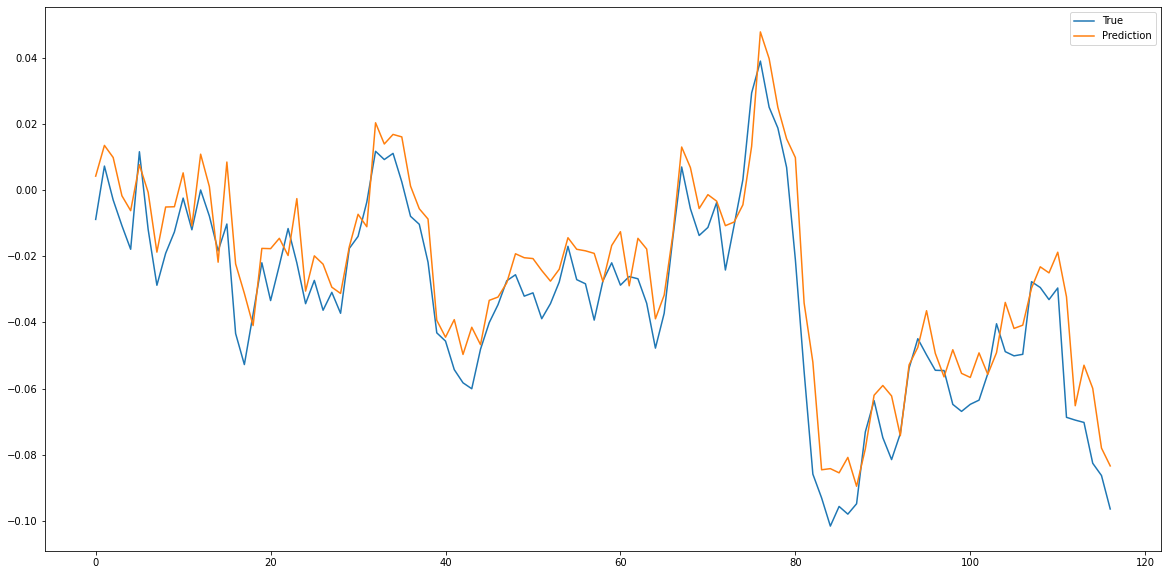

In [9]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()